# 1. Setup Paths for Tensorflow APIs

In [ ]:
import os

In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
import wget
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [ ]:
labels = [{'name':'Mask', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [283]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from pathlib import Path
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
labels = [{'name':'Mask', 'id':1}]
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


In [133]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [210]:
def get_face(image):
    img = cv2.imread(image)

    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    return img,faces

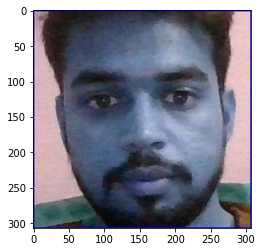

0.63037443
Enter Name: Gagan
Image Saved!


In [254]:

import cv2
  
# Read the input image
img_name = 'TEST/Gagan.jpg'

img, faces = get_face(img_name)
  
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    #plt.imshow(faces)
    cv2.imwrite('face.jpg', faces)
    
height = faces.shape[0]
width = faces.shape[1]

#area of the image
area = height * width

# Cut the image in half horizontally
width_cutoff = height // 2

up = faces[:width_cutoff, :]
down = faces[width_cutoff:, :]

parts = [faces,up,down]
count = 0
IMAGES_PATH = 'Persons_image'

for part in parts:
    class_name ='no'
    image_np = np.array(part)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(image_np_with_detections)
    plt.show()
    
    #to save images
    classes = set(detections['detection_classes'])
    for clas in classes:
        print(detections['detection_scores'][clas])
        if detections['detection_scores'][clas] > 0.7:
            class_name = category_index[clas+1]['name']
            count = count+1
            if class_name == 'no':
                name = input('Enter Name: ')
                imgname = os.path.join(IMAGES_PATH +'.'+'{}.jpg'.format(name))
                cv2.imwrite(imgname, part)
                print('Image Saved!')
        else:
            if class_name == 'no':
                name = input('Enter Name: ')
                imgname = os.path.join(IMAGES_PATH+'/'+'{}.jpg'.format(name))
                part = cv2.cvtColor(part, cv2.COLOR_BGR2RGB)
                cv2.imwrite(imgname, part)
                print('Image Saved!')
            count = 0
    if count == 0:
        break


# Display the output
#cv2.imwrite('detcted.jpg', img)
#plt.imshow( img)
#cv2.waitKey()

In [230]:
def save_and_get_face(image):
    
    img = cv2.imread(image)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = img[y:y + h, x:x + w]
        #plt.imshow(faces)
        faces = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
        cv2.imwrite('face.jpg', faces)
    
    image_path = 'face.jpg'
    
    return image_path

In [284]:
def get_name(image_names, index):
    image_path = image_names[index[0]]
    Name = Path(image_path).stem
    
    return Name
    

In [159]:
import os
import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model


In [160]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 118s 0us/step


In [161]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [162]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


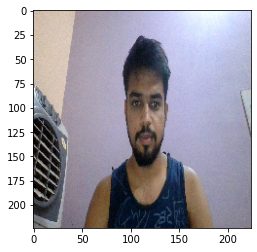

In [267]:
img, x = load_image("TEST/face.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [268]:
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted electric_fan with probability 0.158
predicted hand_blower with probability 0.127
predicted microphone with probability 0.087
predicted dumbbell with probability 0.066
predicted racket with probability 0.052


In [269]:
feat_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer("fc2").output)


In [172]:
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [279]:
images_path = IMAGES_PATH
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]
print(images)
print("keeping %d images to analyze" % len(images))

['Persons_image\\Aish.jpg', 'Persons_image\\Gagan.jpg', 'Persons_image\\Kuldeepak.jpg']
keeping 3 images to analyze


In [271]:
import time
tic = time.perf_counter()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.perf_counter()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.perf_counter()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 3. Time: 0.0001 seconds.
finished extracting features for 3 images


In [272]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA()
pca.fit(features)

PCA()

In [274]:
pca_features = pca.transform(features)

In [275]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [276]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

In [277]:
def get_closest_images(query_image_features, num_results=1):
    distances = [ distance.cosine(query_image_features, feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'Gagan')

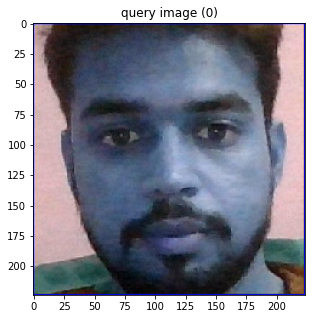

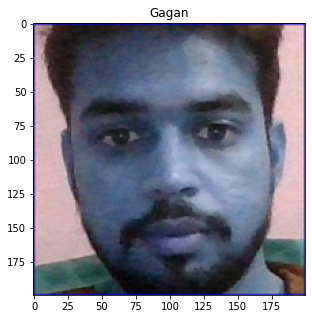

In [287]:
# do a query on a random image
query_image1 = 'TEST/Gagan.jpg'
query_image = save_and_get_face(query_image1)
new_image, x = load_image(query_image)
new_features = feat_extractor.predict(x)

new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]

idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:1]  # grab first 5

results_image = get_concatenated_images(idx_closest, 200)



# display the query image
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image (%d)" % query_image_idx)

name = get_name(images,idx_closest)
# display the resulting images
plt.figure(figsize = (5,5))
plt.imshow(results_image)
plt.title(name)

Aish.jpg
Aish
